# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

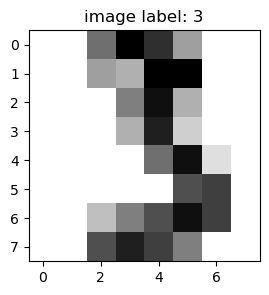

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [16]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X,self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))
        Y_pred = self.forward(X)
        return nll(y_onehot, Y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b
    
# Raise an exception if you try to run this cell without having implemented the LogisticRegression class
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")

In [17]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

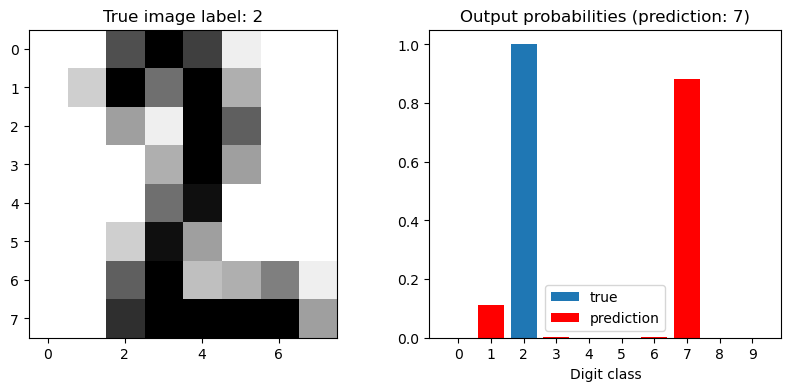

In [18]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)
    

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [19]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 277
Average NLL over the last 100 samples at step 200: 127
Average NLL over the last 100 samples at step 300: 471
Average NLL over the last 100 samples at step 400: 62
Average NLL over the last 100 samples at step 500: 333
Average NLL over the last 100 samples at step 600: 40
Average NLL over the last 100 samples at step 700: 215
Average NLL over the last 100 samples at step 800: 83
Average NLL over the last 100 samples at step 900: 83
Average NLL over the last 100 samples at step 1000: 205
Average NLL over the last 100 samples at step 1100: 158
Average NLL over the last 100 samples at step 1200: 264
Average NLL over the last 100 samples at step 1300: 113
Average NLL over the last 100 samples at step 1400: 79
Average NLL over the last 100 samples at step 1500: 231


Evaluate the trained model on the first example:

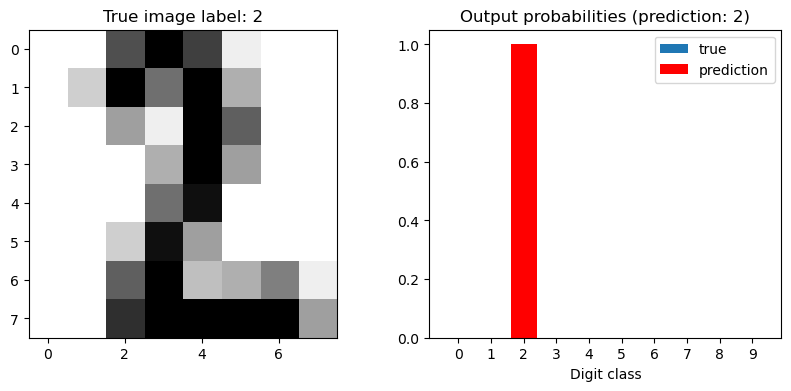

In [20]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

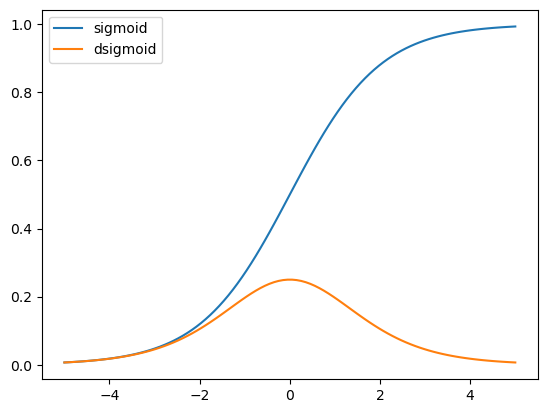

In [21]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    # Use the sigmoid function
    s = sigmoid(X)
    # Derivative: s * (1 - s)
    return s * (1 - s)

x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [22]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)


    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        return sigmoid(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)
        return Y

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.output_size, y)
        Y_pred = self.forward(X)
        return nll(Y_pred, y_onehot)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)
    
# Raise an exception if you try to run this cell without having implemented the NeuralNet class
nn = NeuralNet(input_size=64, hidden_size=32, output_size=10)
try:
    assert(nn.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(nn.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the NeuralNet class.")

Once the code is written, we can test our model on a single sample:

In [23]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [24]:
model.loss(X_train, y_train)

np.float64(238434.26093906432)

In [25]:
model.accuracy(X_train, y_train)

np.float64(0.091683038637852)

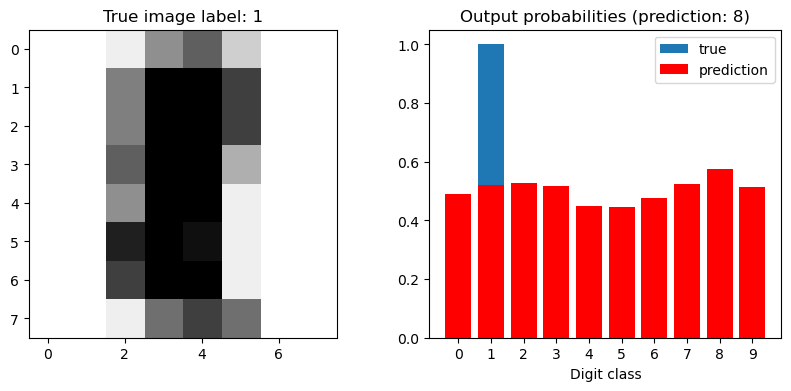

In [26]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [27]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 238434.26094, train acc: 0.092, test acc: 0.130
Epoch #1, train loss: 49882.45260, train acc: 0.291, test acc: 0.230
Epoch #2, train loss: 50538.23545, train acc: 0.540, test acc: 0.489
Epoch #3, train loss: 43378.63214, train acc: 0.711, test acc: 0.693
Epoch #4, train loss: 37524.12901, train acc: 0.828, test acc: 0.785
Epoch #5, train loss: 33250.92503, train acc: 0.859, test acc: 0.811
Epoch #6, train loss: 28534.92532, train acc: 0.887, test acc: 0.830
Epoch #7, train loss: 24841.23478, train acc: 0.904, test acc: 0.870
Epoch #8, train loss: 22099.55906, train acc: 0.917, test acc: 0.900
Epoch #9, train loss: 20698.77933, train acc: 0.922, test acc: 0.904
Epoch #10, train loss: 20163.28644, train acc: 0.929, test acc: 0.907
Epoch #11, train loss: 20088.74670, train acc: 0.933, test acc: 0.915
Epoch #12, train loss: 19524.15771, train acc: 0.936, test acc: 0.919
Epoch #13, train loss: 18478.61740, train acc: 0.938, test acc: 0.919
Epoch #14, train loss: 172

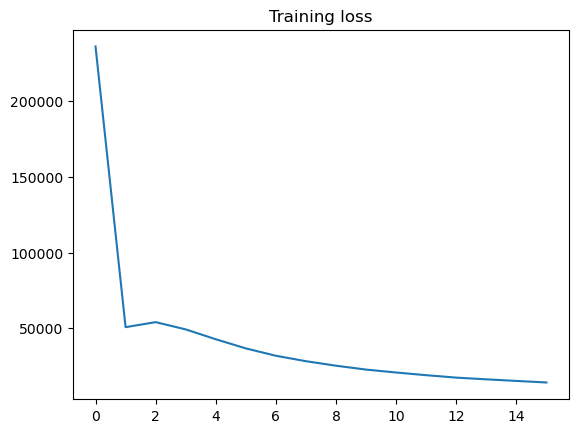

In [31]:
plt.plot(losses)
plt.title("Training loss");

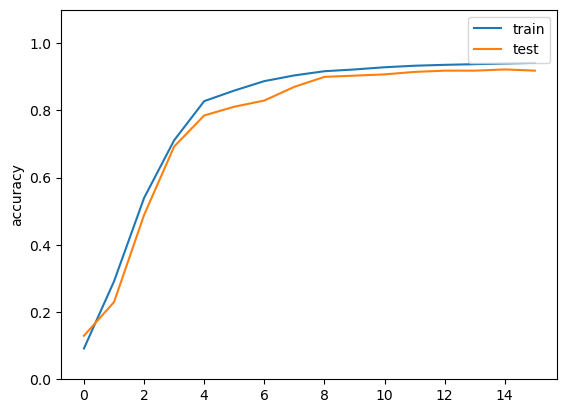

In [28]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

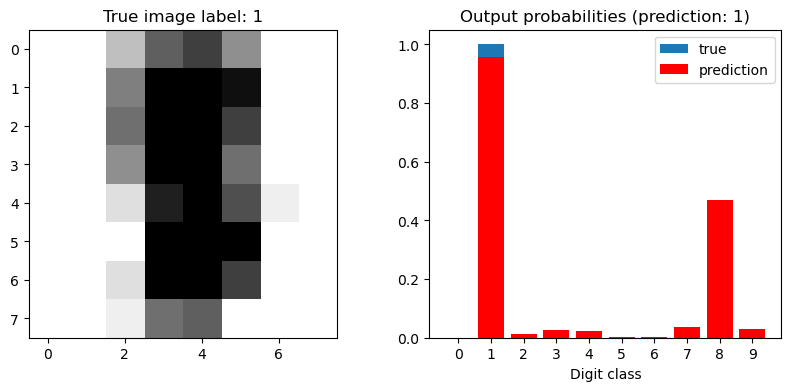

In [29]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

In [30]:
# Forward pass
Y_pred = model.forward(X_test)  # shape: (270, 10)

# Predicted class indices
y_pred_class = np.argmax(Y_pred, axis=1)  # shape: (270,)

# Compute error: 0 if correct, 1 if incorrect
errors = (y_pred_class != y_test.astype(int)).astype(int)

# Get indices of worst predictions (most incorrect)
worst_indices = np.argsort(errors)[-5:]  # Top 5 errors (will be 1s)

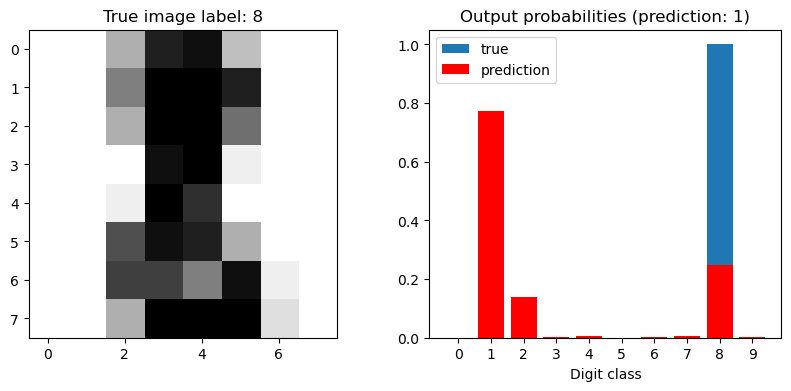

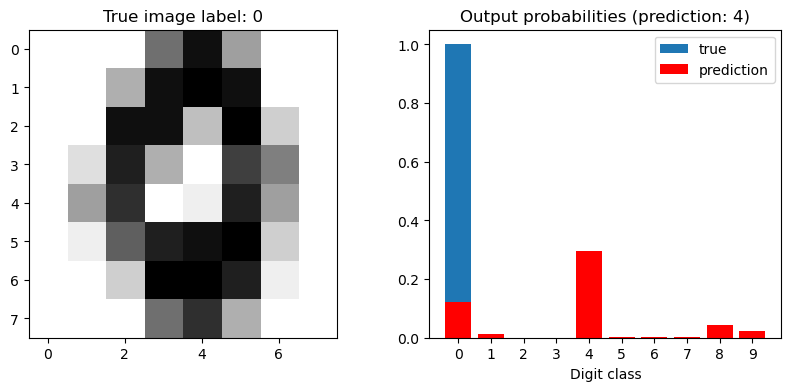

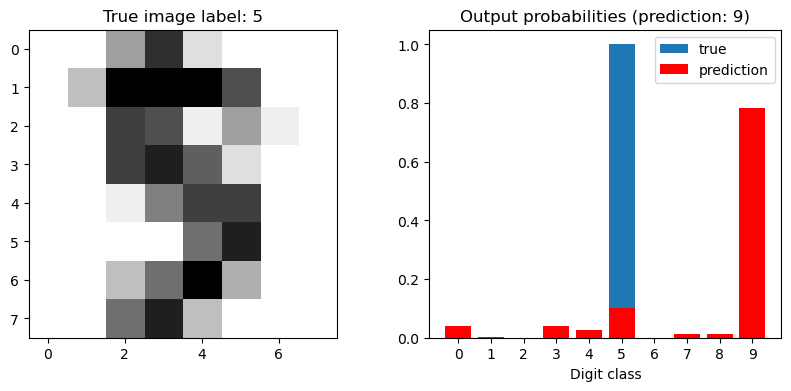

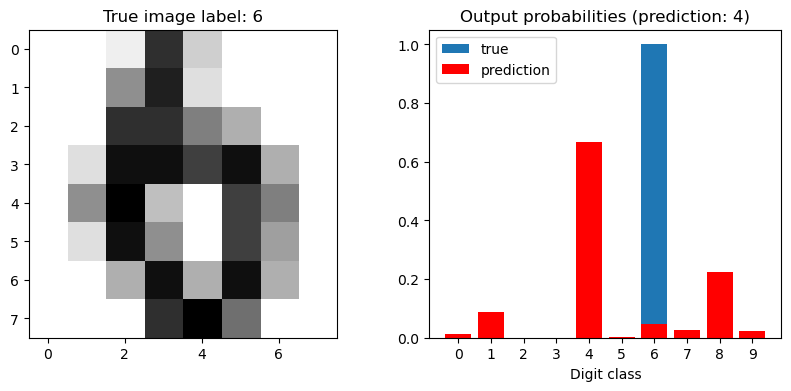

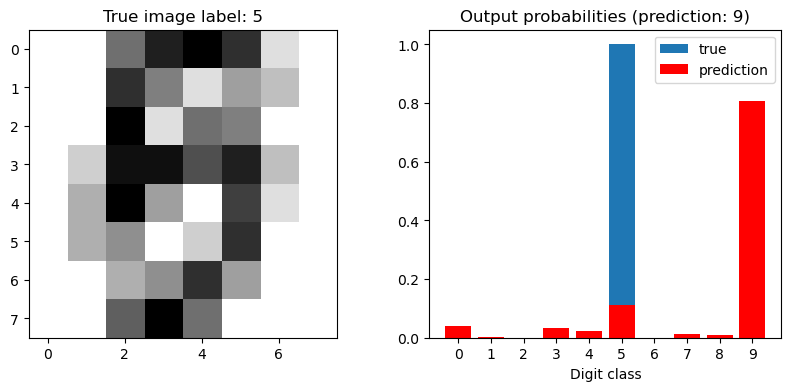

In [35]:
for idx in worst_indices:
    plot_prediction(model, idx)

In [ ]:
# High confidence with wrong predictions

# Confidence of predicted class
confidences = np.max(Y_pred, axis=1)

# Penalize confident wrong predictions
penalty = errors * confidences

# Sort by penalty
worst_indices = np.argsort(penalty)[-5:]

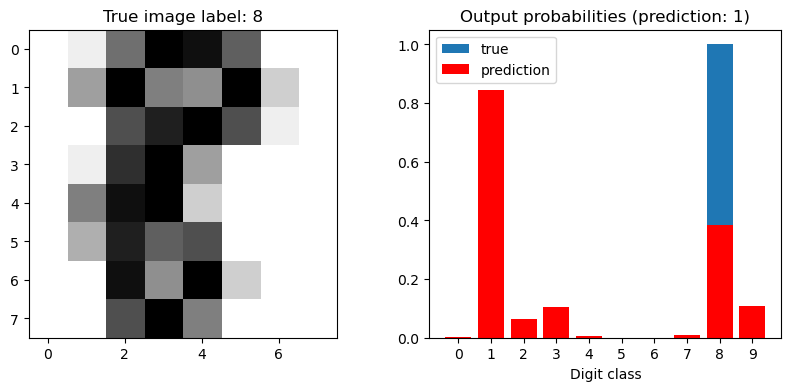

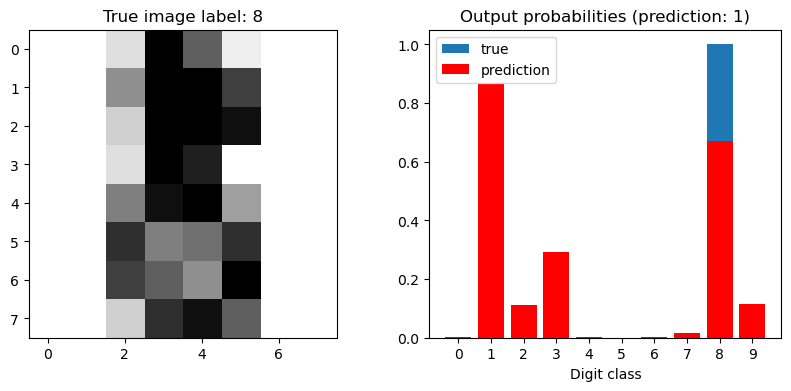

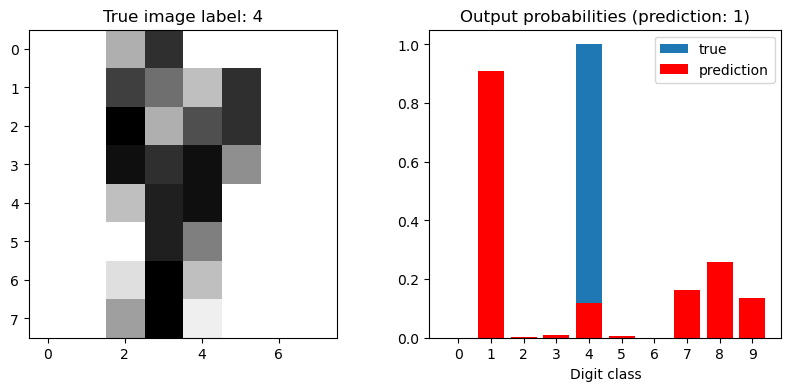

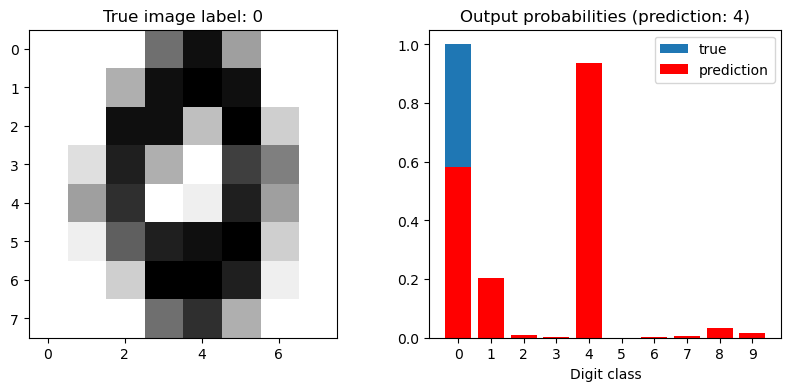

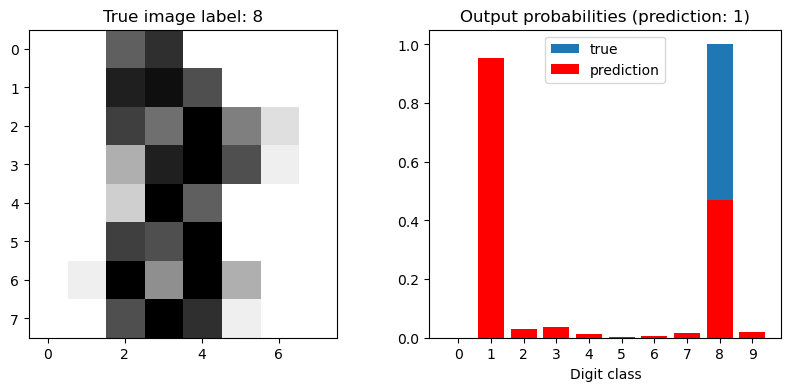

In [32]:
for idx in worst_indices:
    plot_prediction(model, idx)

 1. Maybe the model needs better training data or regularization.
 2. Need to fine-tune hyper parameters.
 3. Add more hidden layer(s).

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [51]:
# Find best hyper paramter values with one hidden layer

size_hidden_layers = [8, 16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.05, 0.1]

for n_hidden in size_hidden_layers:
    
    model = NeuralNet(n_features, n_hidden, n_classes)

    print(f'Loss: {model.loss(X_train, y_train)}')

    print(f'Accuracy: {model.accuracy(X_train, y_train)}')

    # plot_prediction(model, sample_idx=5)

    losses, accuracies, accuracies_test = [], [], []
    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))

    for learning_rate in learning_rates:
        print("Random init: hidden layer size: %0.3f, learning rate: %0.3f, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (n_hidden, learning_rate, losses[-1], accuracies[-1], accuracies_test[-1]))
        # losses, accuracies, accuracies_test = [], [], []
        for epoch in range(15):
            for i, (x, y) in enumerate(zip(X_train, y_train)):
                model.train(x, y, learning_rate)

            losses.append(model.loss(X_train, y_train))
            accuracies.append(model.accuracy(X_train, y_train))
            accuracies_test.append(model.accuracy(X_test, y_test))
            print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
                % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

print(f'Max Accuracy: {np.max(accuracies_test)}')


Loss: 243038.7368785739
Accuracy: 0.10019646365422397
Random init: hidden layer size: 8.000, learning rate: 0.001, train loss: 243038.73688, train acc: 0.100, test acc: 0.089
Epoch #1, train loss: 52684.36079, train acc: 0.195, test acc: 0.163
Epoch #2, train loss: 53041.84233, train acc: 0.326, test acc: 0.285
Epoch #3, train loss: 49006.30706, train acc: 0.707, test acc: 0.696
Epoch #4, train loss: 45190.07048, train acc: 0.786, test acc: 0.774
Epoch #5, train loss: 38774.12555, train acc: 0.839, test acc: 0.796
Epoch #6, train loss: 32730.72831, train acc: 0.864, test acc: 0.815
Epoch #7, train loss: 28056.54199, train acc: 0.878, test acc: 0.833
Epoch #8, train loss: 24991.10877, train acc: 0.884, test acc: 0.844
Epoch #9, train loss: 22530.57755, train acc: 0.890, test acc: 0.856
Epoch #10, train loss: 20623.25960, train acc: 0.892, test acc: 0.859
Epoch #11, train loss: 19183.50134, train acc: 0.897, test acc: 0.863
Epoch #12, train loss: 18031.93654, train acc: 0.899, test acc: 

Loss: 242073.13387568906
Accuracy: 0.10150622134905042
Random init: hidden layer size: 128.000, learning rate: 0.010, train loss: 242073.13388, train acc: 0.102, test acc: 0.089
Epoch #1, train loss: 20586.10984, train acc: 0.814, test acc: 0.804
Epoch #2, train loss: 21128.28966, train acc: 0.804, test acc: 0.800
Epoch #3, train loss: 17703.43261, train acc: 0.832, test acc: 0.826
Epoch #4, train loss: 12753.93156, train acc: 0.878, test acc: 0.841
Epoch #5, train loss: 13476.58745, train acc: 0.881, test acc: 0.863
Epoch #6, train loss: 16814.92633, train acc: 0.883, test acc: 0.848
Epoch #7, train loss: 12344.23099, train acc: 0.885, test acc: 0.881
Epoch #8, train loss: 12378.38554, train acc: 0.927, test acc: 0.885
Epoch #9, train loss: 10727.71501, train acc: 0.917, test acc: 0.889
Epoch #10, train loss: 10767.79170, train acc: 0.944, test acc: 0.915
Epoch #11, train loss: 10206.93167, train acc: 0.897, test acc: 0.885
Epoch #12, train loss: 13595.73138, train acc: 0.912, test ac

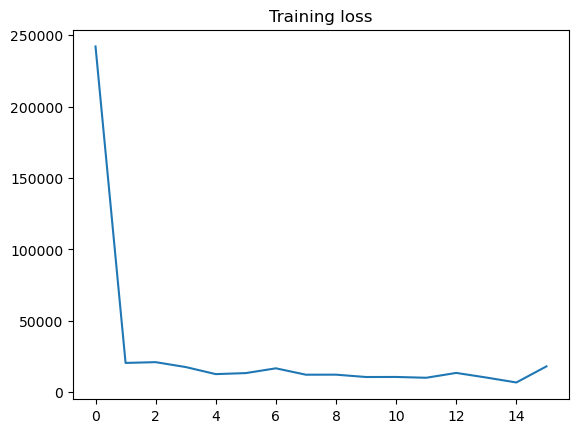

In [53]:
# Re-train model with best hyper parameters

model = NeuralNet(n_features, 128, n_classes)

print(f'Loss: {model.loss(X_train, y_train)}')
print(f'Accuracy: {model.accuracy(X_train, y_train)}')

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: hidden layer size: %0.3f, learning rate: %0.3f, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
% (n_hidden, 0.010, losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.010)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
    
plt.plot(losses)
plt.title("Training loss");



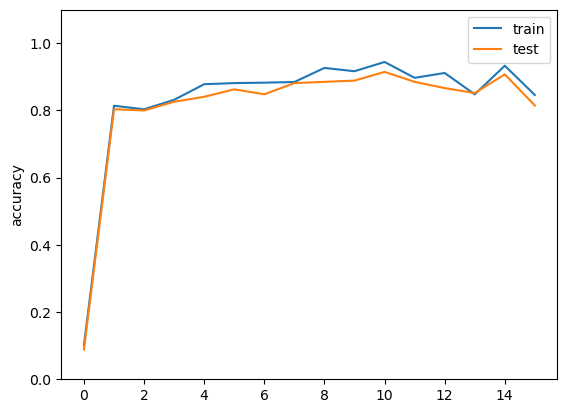

In [54]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

In [57]:
# Addition of 2nd hidden layer

class NeuralNet2Hidden():
    """MLP with 2 hidden layers using sigmoid activation"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # First hidden layer
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size1), high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size1, high=0.1, low=-0.1)

        # Second hidden layer
        self.W_h2 = np.random.uniform(size=(hidden_size1, hidden_size2), high=0.1, low=-0.1)
        self.b_h2 = np.random.uniform(size=hidden_size2, high=0.1, low=-0.1)

        # Output layer
        self.W_o = np.random.uniform(size=(hidden_size2, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)

        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

    def forward_hidden(self, X):
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        self.H1 = sigmoid(self.Z_h1)

        self.Z_h2 = np.dot(self.H1, self.W_h2) + self.b_h2
        self.H2 = sigmoid(self.Z_h2)

        return self.H2

    def forward_output(self, H2):
        self.Z_o = np.dot(H2, self.W_o) + self.b_o
        return sigmoid(self.Z_o)

    def forward(self, X):
        H2 = self.forward_hidden(X)
        Y = self.forward_output(H2)
        return Y

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.output_size, y)
        Y_pred = self.forward(X)
        return nll(Y_pred, y_onehot)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Output layer error
        error_o = y_pred - y_true
        grad_W_o = np.dot(self.H2.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Second hidden layer error
        error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)
        grad_W_h2 = np.dot(self.H1.T, error_h2)
        grad_b_h2 = np.sum(error_h2, axis=0)

        # First hidden layer error
        error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)
        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        return {
            "W_h1": grad_W_h1, "b_h1": grad_b_h1,
            "W_h2": grad_W_h2, "b_h2": grad_b_h2,
            "W_o": grad_W_o, "b_o": grad_b_o
        }

    def train(self, x, y, learning_rate):
        x = x[np.newaxis, :]
        grads = self.grad_loss(x, y)

        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_h2 -= learning_rate * grads["W_h2"]
        self.b_h2 -= learning_rate * grads["b_h2"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [68]:
# Find best hyper parameter values with two hidden layers

size_hidden_layers = [8, 16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.05, 0.1]

for n_hidden in size_hidden_layers:
    
    model = NeuralNet2Hidden(n_features, n_hidden, n_hidden, n_classes)

    print(f'Loss: {model.loss(X_train, y_train)}')

    print(f'Accuracy: {model.accuracy(X_train, y_train)}')

    # plot_prediction(model, sample_idx=5)

    losses, accuracies, accuracies_test = [], [], []
    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))

    for learning_rate in learning_rates:
        print("Random init: hidden layer size: %0.3f, learning rate: %0.3f, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (n_hidden, learning_rate, losses[-1], accuracies[-1], accuracies_test[-1]))
        # losses, accuracies, accuracies_test = [], [], []
        for epoch in range(15):
            for i, (x, y) in enumerate(zip(X_train, y_train)):
                model.train(x, y, learning_rate)

            losses.append(model.loss(X_train, y_train))
            accuracies.append(model.accuracy(X_train, y_train))
            accuracies_test.append(model.accuracy(X_test, y_test))
            print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
                % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

print(f'Max Accuracy: {np.max(accuracies_test)}')


Loss: 235842.6755715479
Accuracy: 0.10150622134905042
Random init: hidden layer size: 8.000, learning rate: 0.010, train loss: 235842.67557, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 47753.22062, train acc: 0.102, test acc: 0.089
Epoch #2, train loss: 47748.41491, train acc: 0.102, test acc: 0.089
Epoch #3, train loss: 47756.08502, train acc: 0.102, test acc: 0.089
Epoch #4, train loss: 47764.88239, train acc: 0.102, test acc: 0.089
Epoch #5, train loss: 47779.44602, train acc: 0.102, test acc: 0.089
Epoch #6, train loss: 47818.69296, train acc: 0.102, test acc: 0.089
Epoch #7, train loss: 48049.05805, train acc: 0.117, test acc: 0.078
Epoch #8, train loss: 47791.88065, train acc: 0.206, test acc: 0.159
Epoch #9, train loss: 47446.64665, train acc: 0.206, test acc: 0.159
Epoch #10, train loss: 46621.66210, train acc: 0.207, test acc: 0.159
Epoch #11, train loss: 45811.12558, train acc: 0.206, test acc: 0.159
Epoch #12, train loss: 44685.98701, train acc: 0.214, test acc: 

Loss: 229795.09057603485
Accuracy: 0.09888670595939751
Random init: hidden layer size: 128.000, learning rate: 0.010, train loss: 229795.09058, train acc: 0.099, test acc: 0.115
Epoch #1, train loss: 39767.01832, train acc: 0.741, test acc: 0.726
Epoch #2, train loss: 22946.96632, train acc: 0.857, test acc: 0.811
Epoch #3, train loss: 13989.76424, train acc: 0.935, test acc: 0.893
Epoch #4, train loss: 9666.36661, train acc: 0.968, test acc: 0.933
Epoch #5, train loss: 7292.31913, train acc: 0.976, test acc: 0.952
Epoch #6, train loss: 5944.11137, train acc: 0.982, test acc: 0.948
Epoch #7, train loss: 5015.22388, train acc: 0.986, test acc: 0.952
Epoch #8, train loss: 4304.72500, train acc: 0.988, test acc: 0.963
Epoch #9, train loss: 3856.87550, train acc: 0.990, test acc: 0.963
Epoch #10, train loss: 3512.98901, train acc: 0.992, test acc: 0.963
Epoch #11, train loss: 3220.38242, train acc: 0.993, test acc: 0.963
Epoch #12, train loss: 2916.52602, train acc: 0.994, test acc: 0.963


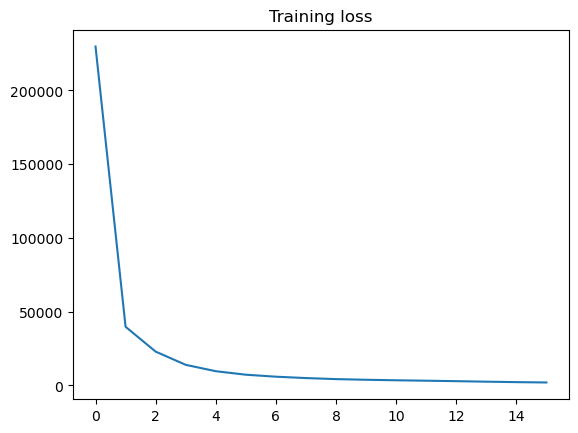

In [69]:
# Re-train model with best hyper parameters

model = NeuralNet2Hidden(n_features, 128, 128, n_classes)

print(f'Loss: {model.loss(X_train, y_train)}')
print(f'Accuracy: {model.accuracy(X_train, y_train)}')

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: hidden layer size: %0.3f, learning rate: %0.3f, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
% (n_hidden, 0.010, losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.010)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
        % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
    
plt.plot(losses)
plt.title("Training loss");



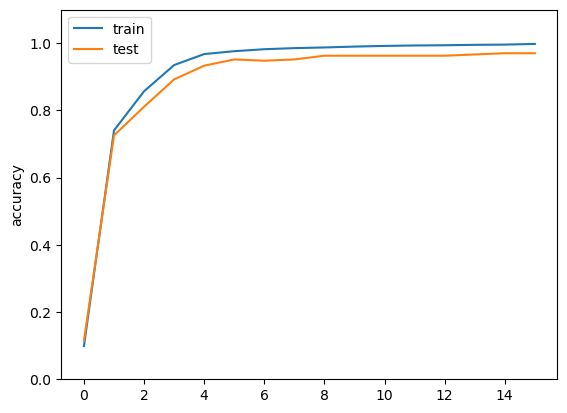

In [70]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best')

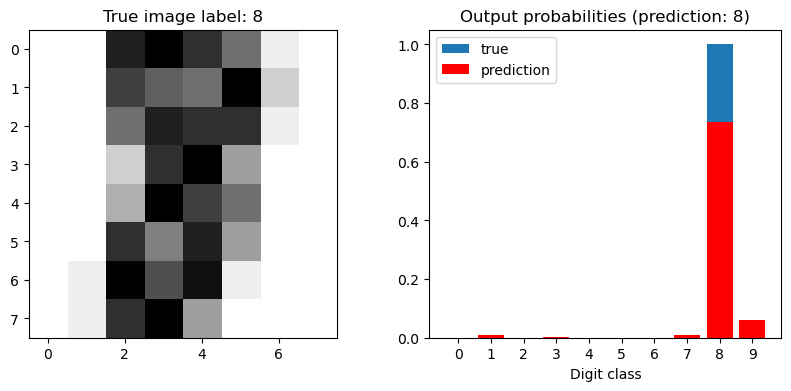

In [72]:
plot_prediction(model, sample_idx=15)